# Datos ERE y ERTE solicitados y resueltos en la Comunitat Valenciana 2022-08-10

________________________________________________________________________________


Los datos recopilados para este estudio, engloban los datos de todas las solicitudes presentadas por las empresas sobre extinciones, reducciones y suspensiones de empleo. Existen registros desde el año 2000 hasta Agosto de 2022. Estos datos estan segmentados por genero, justificando la causa de la presentación, el sector al que pertenecen, la ubicacion de la sede de la empresa y ante que órgano se ha presentado la solicitud entre otros datos.

En este estudio nos centraremos en la evolución que han tenido las solicitudes de ERTES en la Comunidad Valenciana desde 2010 hasta la actualidad.

Con pandas limpiaremos los datos y nos centraremos unicamente en las presentaciones de suspensiones de empleo. Generaremos una serie de medidas para calcular las variaciones por año, por sector, por causa y género para intentar identificar algunos patrones o datos atípicos que puedan ser interesantes durante este periodo.


Tambien hemos cargado un dataset con las longitudes y latitudes de los municipios de España que utilizaremos para plotear las sedes de las empresas.


Para ello utilizaremos librerias como seaborn o ploty para generar graficos que nos ayuden a visualizar los resultados de una manera eficiente.

________________________________________________________________________________


###  Importación y actualizacion de paquetes.

In [ ]:
# Actualizamos la libreria ploty para graficar mapas.

!pip install --upgrade plotly
import plotly
print(plotly.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
5.10.0


In [ ]:
# Actualizamos la libreria xlrd para leer ficheros EXCEL.

!pip install --upgrade xlrd
import xlrd
print(xlrd.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.0.1


In [ ]:
# Ahora importamos los paquetes con los que vamos a trabajar.

import pandas as pd
import numpy as np
import datetime 
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Carga de datos

In [ ]:
# Descargamos nuestro dataset principal que hemos guardado previamente en Google Drive.

!gdown https://drive.google.com/uc?id=1Hu9NEVK0sIbpbQWHmqgaXtXM3KikfVLg

Downloading...
From: https://drive.google.com/uc?id=1Hu9NEVK0sIbpbQWHmqgaXtXM3KikfVLg
To: /content/datos-ere-y-erte-solicitados-y-resueltos-en-la-comunitat-valenciana-2022-08-10.csv
100% 25.4M/25.4M [00:00<00:00, 116MB/s] 


In [ ]:
# Descargamos nuestro dataset secundario con los datos de las localizaciones que tambien hemos guardado en Google Drive.

! gdown 1a55l1Rig1_D71weA4zPe_fnSKx_ZwDVP

Downloading...
From: https://drive.google.com/uc?id=1a55l1Rig1_D71weA4zPe_fnSKx_ZwDVP
To: /content/listado-longitud-latitud-municipios-espana.xls
100% 1.35M/1.35M [00:00<00:00, 79.7MB/s]


### Lectura del dataset principal

In [ ]:
# Leemos el dataset principal.

df = pd.read_csv('/content/datos-ere-y-erte-solicitados-y-resueltos-en-la-comunitat-valenciana-2022-08-10.csv',sep=';')

# Obtenemos un error en las columnas 27,28,29 por que contienen datos mixtos. Las columnas deberian ser de tipo fecha, pero no vamos a utilizarlas para el 
# análisis, asi que no necesitamos especificar el tipo de datos en este caso.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (27,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
# Primer vistazo a los datos para ver que tenemos entre manos.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112164 entries, 0 to 112163
Data columns (total 43 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   FECHA_SOLICITUD       112164 non-null  object
 1   EMPRESA_PROV          112164 non-null  int64 
 2   PROVINCIA             112164 non-null  object
 3   EMPRESA_MUN           112164 non-null  int64 
 4   MUNICIPIO             111794 non-null  object
 5   SECTOR                112164 non-null  object
 6   AUTORIDAD_LABORAL     112164 non-null  object
 7   COD_CNAE              112164 non-null  int64 
 8   DESC_CNAE             112164 non-null  object
 9   MOTIVO_SOLICITADO     112164 non-null  object
 10  CAUSA                 112164 non-null  object
 11  SOLICITA_EXTINCION    112164 non-null  object
 12  SOLICITA_REDUCCION    112164 non-null  object
 13  SOLICITA_SUSPENSION   112164 non-null  object
 14  TOTAL_TRAB_EXT        112164 non-null  int64 
 15  TRAB_HOMBRES_EXT 

________________________________________________________________________________


Despues de un primer vistazo a los datos, desechamos las columnas que no son necesarias para nuestro trabajo. 

Nos quedamos con las siguientes columnas:

- FECHA_SOLICITUD --> Fecha generada el dia de la solicitud
- PROVINCIA --> Provincia en la que la empresa tiene su sede social.
- MUNICIPIO --> Municipio en el que la empresa tiene su sede social.
- SECTOR --> Sector al que pertenecen las empresas
- CAUSA --> Causa de la solicitud del expediente de regulación
- TOTAL_CON_TRAB_SUS --> Total de trabajadores con concesión de suspensión
- TRAB_HOMBRES_SUS --> Hombres para los cuales se ha solicitado suspensión
- TRAB_MUJERES_SUS --> Mujeres para las cuales se ha solicitado suspensión
- TRAB_SINDET_SUS --> Personas de género indeterminado para las cuales se ha solicitado suspensión


________________________________________________________________________________



### Limpieza del dataset principal

In [ ]:
# Hacemos una pequeña limpieza, cambiando el tipo de datos de la columna FECHA_SOLICTUD de objeto a fecha, 
# renombrando las columnas y extrayendo en dos columnas independientes, el AÑO y el MES para su posterior analisis.
# Importante mapear la columna MES, usando condicionales, para cambiar los numeros por los meses en formato texto.


df = (
      df.filter(['FECHA_SOLICITUD','PROVINCIA','MUNICIPIO','SECTOR','CAUSA',
                 'TOTAL_TRAB_SUS','TRAB_HOMBRES_SUS','TRAB_MUJERES_SUS','TRAB_SINDET_SUS'])
      
        .rename(columns={'CAUSA':'CAUSA_SUSPENSION','TOTAL_TRAB_SUS':'TOTAL_TRAB_SUSPENDIDOS','TRAB_HOMBRES_SUS':'TRAB_HOMBRES_SUSPENDIDOS',
                         'TRAB_MUJERES_SUS':'TRAB_MUJERES_SUSPENDIDAS','TRAB_SINDET_SUS':'TRAB_GENERO_NO_DEFINIDO_SUSPENSION'})
        
        .assign(FECHA_SOLICITUD = lambda x: pd.to_datetime(x.FECHA_SOLICITUD),
                MES = lambda x: x.FECHA_SOLICITUD.dt.month,
                AÑO = lambda x: x.FECHA_SOLICITUD.dt.year)
        
        .assign(MES = lambda x: x.MES.map(lambda value: 'Enero' if value == 1 else 'Febrero' if value == 2 else 'Marzo' if value == 3 else
                                                        'Abril' if value == 4 else 'Mayo' if value == 5 else 'Junio' if value == 6 else
                                                        'Julio' if value == 7 else 'Agosto' if value == 8 else 'Septiembre' if value == 9 else
                                                        'Octubre' if value == 10 else ' Noviembre' if value == 11 else 'Diciembre'))

        .query('AÑO >= 2010')
     )

# ===========================================================================================================
# Este ultimo paso lo hacemos aparte porque no reconoce la columna MES hasta que no materializamos el dataset.

df = df.assign(MES_AÑO = df['MES'].astype(str) + "-" + df['AÑO'].astype(str))

In [ ]:
# Esto nos devuelve un dataset limpio en el que es mas sencillo trabajar, sin nulos.

df.sample(5)

,FECHA_SOLICITUD,PROVINCIA,MUNICIPIO,SECTOR,CAUSA_SUSPENSION,TOTAL_TRAB_SUSPENDIDOS,TRAB_HOMBRES_SUSPENDIDOS,TRAB_MUJERES_SUSPENDIDAS,TRAB_GENERO_NO_DEFINIDO_SUSPENSION,MES,AÑO,MES_AÑO
56485,2020-03-28,Valencia/València,Moixent/Mogente,SERVICIOS,FUERZA MAYOR,7,2,5,0,Marzo,2020,Marzo-2020
70056,2020-03-23,Alicante/Alacant,Benidorm,SERVICIOS,FUERZA MAYOR,1,0,1,0,Marzo,2020,Marzo-2020
42293,2020-03-31,Alicante/Alacant,Benidorm,SERVICIOS,FUERZA MAYOR,10,8,2,0,Marzo,2020,Marzo-2020
96402,2012-03-01,Valencia/València,València,SERVICIOS,ECONÓMICA,0,0,0,0,Marzo,2012,Marzo-2012
31368,2020-04-03,Madrid,Madrid,SERVICIOS,FUERZA MAYOR,5,0,5,0,Abril,2020,Abril-2020


### Lectura del dataset secundario (geo-localización)

In [ ]:
# Leemos el dataset secundario

df_localizacion = pd.read_excel('/content/listado-longitud-latitud-municipios-espana.xls')

In [ ]:
# Este parece que no viene en un formato correcto asi que vamos a ver que ocurre y a procedemos a limpiarlo.

df_localizacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 9 columns):
 #   Column                                                                                                   Non-Null Count  Dtype 
---  ------                                                                                                   --------------  ----- 
 0   Listado preparado por "Business Intelligence fácil" a partir de la información del INE y de Google Maps  8114 non-null   object
 1   Unnamed: 1                                                                                               8114 non-null   object
 2   Unnamed: 2                                                                                               8113 non-null   object
 3   Unnamed: 3                                                                                               8113 non-null   object
 4   Unnamed: 4                                                                                 

In [ ]:
# Comprobamos que los encabezamientos de columnas estan como valores en filas y ademas tenemos columnas con datos como la poblacion o la altitud que no vamos a necesitar.

df_localizacion.head()

,"Listado preparado por ""Business Intelligence fácil"" a partir de la información del INE y de Google Maps",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Más información en:,htttp://www.businessintelligence.info,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Comunidad,Provincia,Población,Latitud,Longitud,Altitud,Habitantes,Hombres,Mujeres
2,Andalucía,Almería,Abla,37.14114,-2.780104,871.1684,1504,783,721
3,Andalucía,Almería,Abrucena,37.13305,-2.797098,976.9387,1341,682,659
4,Andalucía,Almería,Adra,36.74807,-3.022522,10.97898,24373,12338,12035


### Limpieza del dataset secundario (geo-localización)

In [ ]:
# Solo nos interesa las coordenadas y el municipio asi que primero borramos las columnas que no necesitamos.

df_localizacion = df_localizacion.drop(df_localizacion.columns[[0,1,-1,-2,-3,-4]], axis='columns')

In [ ]:
# Una vez hecho esto, colocamos los encabezamientos de las columnas correctamente y los renombramos.

df_localizacion = (
                    df_localizacion.set_axis(df_localizacion.iloc[1].to_list(),axis='columns')
                                   .drop([0,1])
                                   .rename(columns={'Población':'MUNICIPIO','Latitud':'LATITUD','Longitud':'LONGITUD'})                          
                  )

In [ ]:
# Ya tenemos el dataset preparado para unirlo a nuestro dataset principal.

df_localizacion.sample(5)

,MUNICIPIO,LATITUD,LONGITUD
6839,Arroyomolinos,40.26884,-3.920291
2562,Huerta de Valdecarábanos,39.86433,-3.611917
4695,Almaraz de Duero,41.47585,-5.916526
4432,Taroda,41.34843,-2.43388
6873,Colmenarejo,40.56101,-4.016842


### Union de los dos Dataframe

In [ ]:
# Hacemos un join por la clave muncipio, pero unicamente por las filas que coincidan, para evitar asi datos duplicados.

df_final = pd.merge(df,df_localizacion,on='MUNICIPIO',how='inner')

In [ ]:
# Comprobamos que los resultados son los esperados.
# Efectivamente tenemos un dataset limpio con las columnas que necesitamos.

df_final.sample(5)

,FECHA_SOLICITUD,PROVINCIA,MUNICIPIO,SECTOR,CAUSA_SUSPENSION,TOTAL_TRAB_SUSPENDIDOS,TRAB_HOMBRES_SUSPENDIDOS,TRAB_MUJERES_SUSPENDIDAS,TRAB_GENERO_NO_DEFINIDO_SUSPENSION,MES,AÑO,MES_AÑO,LATITUD,LONGITUD
25169,2020-03-24,Alicante/Alacant,Castalla,SERVICIOS,FUERZA MAYOR,1,1,0,0,Marzo,2020,Marzo-2020,38.59519,-0.672251
12274,2021-02-22,Valencia/València,Vilamarxant,INDUSTRIA,FUERZA MAYOR,3,1,2,0,Febrero,2021,Febrero-2021,39.56751,-0.622273
14713,2021-01-28,Alicante/Alacant,Orihuela,SERVICIOS,FUERZA MAYOR,3,2,1,0,Enero,2021,Enero-2021,38.08395,-0.944783
8638,2021-01-25,Alicante/Alacant,Muro de Alcoy,SERVICIOS,FUERZA MAYOR,1,1,0,0,Enero,2021,Enero-2021,38.78075,-0.44027
37511,2020-03-24,Alicante/Alacant,Novelda,SERVICIOS,FUERZA MAYOR,1,0,1,0,Marzo,2020,Marzo-2020,38.3853,-0.765386


# Visualizaciones

### Numero de visualizaciones por año

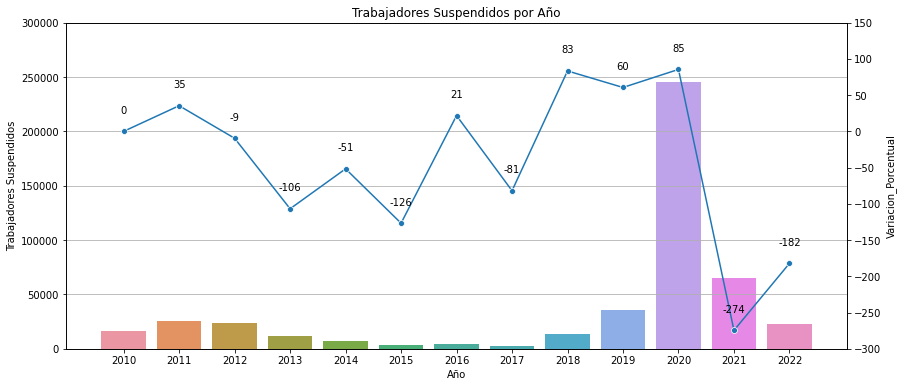

In [ ]:
# Creamos un dataframe agrupado por año con el total de trabajadores suspendidos de empleo. 
# Creamos una columna calcula la variacion porcentual respecto al año anterior.

Solicitudes_Año = (
                    df_final.filter(['AÑO','TOTAL_TRAB_SUSPENDIDOS']).groupby('AÑO').sum('TOTAL_TRAB_SUSPENDIDOS')
                            .assign(Variacion_Porcentual = lambda x: (x.TOTAL_TRAB_SUSPENDIDOS - x.TOTAL_TRAB_SUSPENDIDOS.shift(1))/(x.TOTAL_TRAB_SUSPENDIDOS)*100)
                            .replace(np.nan,0)
                            .round(2)
                            .reset_index()
                  )

# Creamos la figura
fig, ax1 = plt.subplots(figsize=(14,6))
plt.grid()

# Ploteamos dos graficos sobre la misma figura
# Como ax1 un barplot y como ax2 un lineplot.
sns.barplot(x= 'AÑO', y = 'TOTAL_TRAB_SUSPENDIDOS', data= Solicitudes_Año, ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data = Solicitudes_Año['Variacion_Porcentual'], marker='o', sort = False, ax=ax2)

# Añadimos los nombres de los ejes y el titulo.
ax1.set_ylabel('Trabajadores Suspendidos')
ax2.set_ylabel('Variacion_Porcentual')
ax1.set_xlabel('Año')
plt.title('Trabajadores Suspendidos por Año')
plt.xticks(rotation=60)

# Usamos un bucle for para etiquetar la variacion porcentual, mejorando la visualizacion.
for i, v in enumerate(Solicitudes_Año['Variacion_Porcentual']):
    ax2.text(i, v+25, "%d" %v, ha="center")

# Ajustamos los limites de ambos ejes Y para no solapar ninguna etiqueta con los bordes.  
ax1.set_ylim(-10, 300000)
ax2.set_ylim(-300, 150);

________________________________________________________________________________

Como podemos comprobar, los años donde mas suspensión de empleo hubo fueron 2020 y 2021.

Si analizamos la linea que representa la variación porcentual, observamos que del 2017 al 2018 hubo un incremento muy considerable del 87%.
Al año siguiente, del 2018 al 2019 hay otro incremento del 60%.
Finalmente, comprobamos el incremento del 85% respecto del 2019 al 2020.

Gráficamente, puede dar lugar a engaño , pero estamos hablando de un 228% de incremento de trabajadores suspendidos de empleo en 3 años.

________________________________________________________________________________


### Provincias mas afectadas desde 01/2010 hasta 08/2022

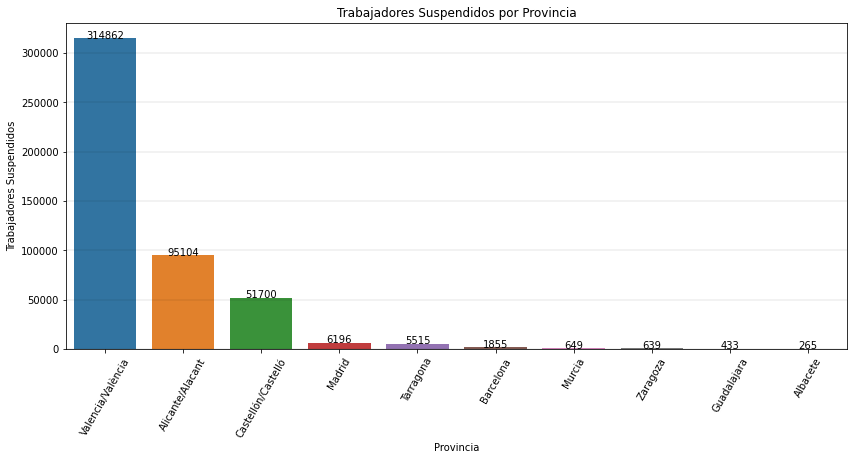

In [ ]:
# Para este grafico vamos a utilizar un dataframe agrupado por provincia con la suma de todos los trabajadores suspendidos.
# Ordenamos los valores de mayor a menor, resteamos el indice para tener las dos variables disponibles y nos quedamos con los 10 primeros registros.

Provincias_mas_afectadas = (
                             df_final.filter(['PROVINCIA','TOTAL_TRAB_SUSPENDIDOS'])
                                     .groupby('PROVINCIA').sum('TOTAL_TRAB_SUSPENDIDOS')
                                     .sort_values('TOTAL_TRAB_SUSPENDIDOS',ascending=False)
                                     .reset_index()
                                     .head(10)
                           )

# Definimos el tamaño y el diseño de la figura.              
plt.figure(figsize=(14,6))
plt.grid(color='black', linestyle='-', linewidth=2, alpha=0.05)

# Ploteamos los datos de nuestro dataframe.
sns.barplot(x= 'PROVINCIA', y = 'TOTAL_TRAB_SUSPENDIDOS', data= Provincias_mas_afectadas)

# Usamos un bucle for para etiquetar los valores absolutos, mejorando la visualizacion.
for i, v in enumerate(Provincias_mas_afectadas['TOTAL_TRAB_SUSPENDIDOS']):
    plt.text(i, v+25, "%d" %v, ha="center")

# Etiquetamos los ejes y el titulo del grafico.
plt.ylabel('Trabajadores Suspendidos')
plt.xlabel('Provincia')
plt.title('Trabajadores Suspendidos por Provincia')
plt.xticks(rotation=60);

________________________________________________________________________________

En este gráfico, intentamos comprobar que provincia ha resultado mas afectada a lo largo de los ultimos años.

Hay que tener en cuenta que nuestros datos provienen de un dataset de la GVA, con lo que tiene sentido que las provincias principalmente afectadas, pertenezcan a la GVA.

Aunque a primera vista pueda parecer que esta claro que provincias estan mas afectadas, me surgen unas dudas...

1- Que poblaciones tienen las 3 provincias de la GVA?

2- Es proporcional a la poblacion el numero de trabajadores afectados?

Vamos a resolverlo:

Para ello facilitare unos datos que despues materializaremos en un dataset
para hacerlo mas visible

- Valencia --> 2.589.312 habitantes 
- Alicante --> 1.881.762 habitantes 
- Castellón --> 587.064 habitantes

** Datos extraidos del censo de la GVA

________________________________________________________________________________



In [ ]:
# Creamos una tabla con los totales agrupados y nos quedamos unicamente con los 3 primeros registros (Valencia, Alicante y Castellon).

df_poblacion_afectada = (
                          df_final.filter(['PROVINCIA','TOTAL_TRAB_SUSPENDIDOS'])
                                .groupby('PROVINCIA').sum('TOTAL_TRAB_SUSPENDIDOS')
                                .sort_values('TOTAL_TRAB_SUSPENDIDOS',ascending=False)
                                .reset_index()
                                .head(3)                    
                        )

# Insertamos una columna a mano con la poblacion.
df_poblacion_afectada.insert(2,"POBLACION",[2589312,1881762,587064])

# Hacemos el calculo para comprobar el porcentaje de afectados respecto a la población.
df_poblacion_afectada.assign(PORCENTAJE_POBLACION_AFECTADA = lambda x: x.TOTAL_TRAB_SUSPENDIDOS/x.POBLACION*100).round(2)

,PROVINCIA,TOTAL_TRAB_SUSPENDIDOS,POBLACION,PORCENTAJE_POBLACION_AFECTADA
0,Valencia/València,314862,2589312,12.16
1,Alicante/Alacant,95104,1881762,5.05
2,Castellón/Castelló,51700,587064,8.81


________________________________________________________________________________

Una vez tenemos los resultados, observamos que la mas afectada sigue siendo Valencia, pero que la segunda mayor afectada, si nos centramos en la población porcentual, es Castellón.

Castellón presenta un 8.81% frente al 5.05% que tiene Alicante lo que el impacto de la suspension de empleo podemos determinar que fue mayor en Castellón.

________________________________________________________________________________


### Numero de suspensiones por genero

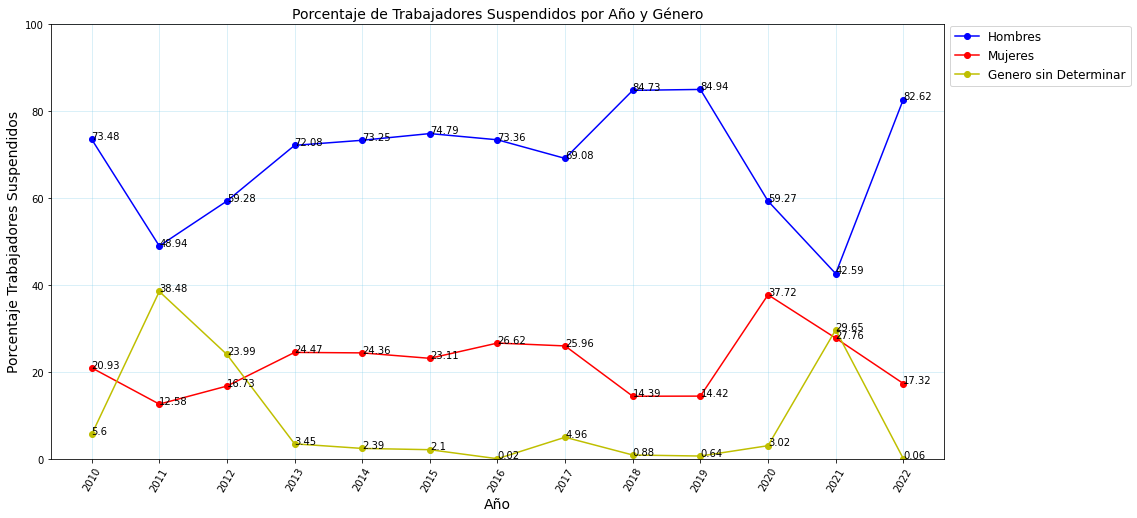

In [ ]:
# Para generar el siguiente gráfico, hemos utilizado las variables categóricas de genero.
# Sobre nuestras columnas de genero, una vez renombradas, hemos calculado los porcentajes parciales respecto al total de empleados suspendidos.
# Asi podemos comprobar de manera porcentual sobre quien ha recaido el mayor impacto.

Solicitudes_por_Genero = (
                           df_final.filter(['AÑO','TOTAL_TRAB_SUSPENDIDOS','TRAB_HOMBRES_SUSPENDIDOS','TRAB_MUJERES_SUSPENDIDAS','TRAB_GENERO_NO_DEFINIDO_SUSPENSION'])
                                   .groupby('AÑO').sum()
                                   .rename(columns={'TOTAL_TRAB_SUSPENDIDOS':'TOTAL_TRABAJADORES_SUSPENDIDOS',
                                                    'TRAB_HOMBRES_SUSPENDIDOS':'PORCENTAJE_HOMBRES',
                                                    'TRAB_MUJERES_SUSPENDIDAS':'PORCENTAJE_MUJERES',
                                                    'TRAB_GENERO_NO_DEFINIDO_SUSPENSION':'PORCENTAJE_SIN_DEFINIR'})
                                   .assign( PORCENTAJE_HOMBRES = lambda x: x.PORCENTAJE_HOMBRES/x.TOTAL_TRABAJADORES_SUSPENDIDOS*100,
                                            PORCENTAJE_MUJERES = lambda x: x.PORCENTAJE_MUJERES/x.TOTAL_TRABAJADORES_SUSPENDIDOS*100,
                                            PORCENTAJE_SIN_DEFINIR = lambda x: x.PORCENTAJE_SIN_DEFINIR/x.TOTAL_TRABAJADORES_SUSPENDIDOS*100)
                                   .replace(np.nan,0)
                                   .round(2)
                                   .reset_index()
                         )

# Definimos la el tamaño de la figura.
plt.figure(figsize=(16, 8))
plt.grid(color='skyblue',alpha=0.6, linewidth=0.5)

# Ploteamos las variables una encima de la otra.
plt.plot(Solicitudes_por_Genero['AÑO'],Solicitudes_por_Genero['PORCENTAJE_HOMBRES'],label="Hombres", color="b", marker='o')
plt.plot(Solicitudes_por_Genero['AÑO'],Solicitudes_por_Genero['PORCENTAJE_MUJERES'], label="Mujeres", color="r", marker='o')
plt.plot(Solicitudes_por_Genero['AÑO'],Solicitudes_por_Genero['PORCENTAJE_SIN_DEFINIR'], label="Genero sin Determinar", color="y", marker='o')

# Ajustamos la escala de 0 a 100 y ponemos nombre a los ejes.
plt.ylabel('Porcentaje Trabajadores Suspendidos',fontsize=14)
plt.xlabel('Año',fontsize=14)
plt.title('Porcentaje de Trabajadores Suspendidos por Año y Género',fontsize=14)
plt.ylim(0, 100)
plt.xticks(Solicitudes_por_Genero['AÑO'])
plt.legend(bbox_to_anchor=(1, 1.01), loc=2, frameon=True,fontsize=12)
plt.xticks(rotation=60)

# Con los bucles for que usamos aqui, etiquetamos cada una de las lineas ploteadas en el grafico.
for i, txt in enumerate(Solicitudes_por_Genero['PORCENTAJE_HOMBRES']):
    plt.annotate(str(txt), (Solicitudes_por_Genero['AÑO'][i],Solicitudes_por_Genero['PORCENTAJE_HOMBRES'][i]))
    
for i, txt in enumerate(Solicitudes_por_Genero['PORCENTAJE_MUJERES']):
    plt.annotate(str(txt), (Solicitudes_por_Genero['AÑO'][i],Solicitudes_por_Genero['PORCENTAJE_MUJERES'][i]))
    
for i, txt in enumerate(Solicitudes_por_Genero['PORCENTAJE_SIN_DEFINIR']):
    plt.annotate(str(txt), (Solicitudes_por_Genero['AÑO'][i],Solicitudes_por_Genero['PORCENTAJE_SIN_DEFINIR'][i]));       

________________________________________________________________________________

** Primero recalcar que estamos comparando los porcentajes por genero y año.

- Claramente hay un mayor porcentaje de hombres afectados desde 2010 a 2022. 
- Le siguen las mujeres como segundo grupo mas afectado.
- En tercer lugar tenemos las personas con genero sin determinar, bien por falta de datos o por motivos personales. Desconocemos la razón.

Lo que si podemos ver en la gráfica, es que hay un descenso de suspensiones en hombres durante los años de pandemia, el cual podemos deducir, que es debido a que fue un acontecimiento que afecto a todos los generos por igual. 

Como datos a destacar, tenemos un 38,5% de afectados sin genero, en 2011.
No sabemoos si debido a que un sector en particular empleara personas sin genero definido, o porque el campo de estos datos esta incompleto.
En 2021 ocurre algo parecido. 

Intentaremos profundizar en ello mas adelante.

________________________________________________________________________________



In [ ]:
# Pasamos un mapa de calor a nuestro DataFrame coloreando los valores mas altos de cada columna para identificarlos mas facilmente.

cm = sns.diverging_palette(250,10, as_cmap=True)
Solicitudes_por_Genero.set_index('AÑO').style.background_gradient(cmap=cm).format(precision= 2)

,TOTAL_TRABAJADORES_SUSPENDIDOS,PORCENTAJE_HOMBRES,PORCENTAJE_MUJERES,PORCENTAJE_SIN_DEFINIR
AÑO,,,,
2010,16755,73.48,20.93,5.60
2011,25927,48.94,12.58,38.48
2012,23668,59.28,16.73,23.99
2013,11445,72.08,24.47,3.45
2014,7545,73.25,24.36,2.39
2015,3328,74.79,23.11,2.10
2016,4253,73.36,26.62,0.02
2017,2338,69.08,25.96,4.96
2018,14055,84.73,14.39,0.88


En esta tabla hemos añadido una columna con los valores absolutos de cada año,
incluyendo un mapa de calor por columna.

De esta forma podemos idenfificar rapidamente los valores y los porcentajes mas elevados.


** Una vez observados los valores absolutos, afirmamos que el año 2011 y 2012 fueron años con una alta tasa de suspension de empleo, pero para este analisis, nos centraremos en la curva que presenta la grafica de 2019 a 2022.

** Procederemos a segmentatar por sector y determinar la causa de las presentaciones durante ese periodo

________________________________________________________________________________


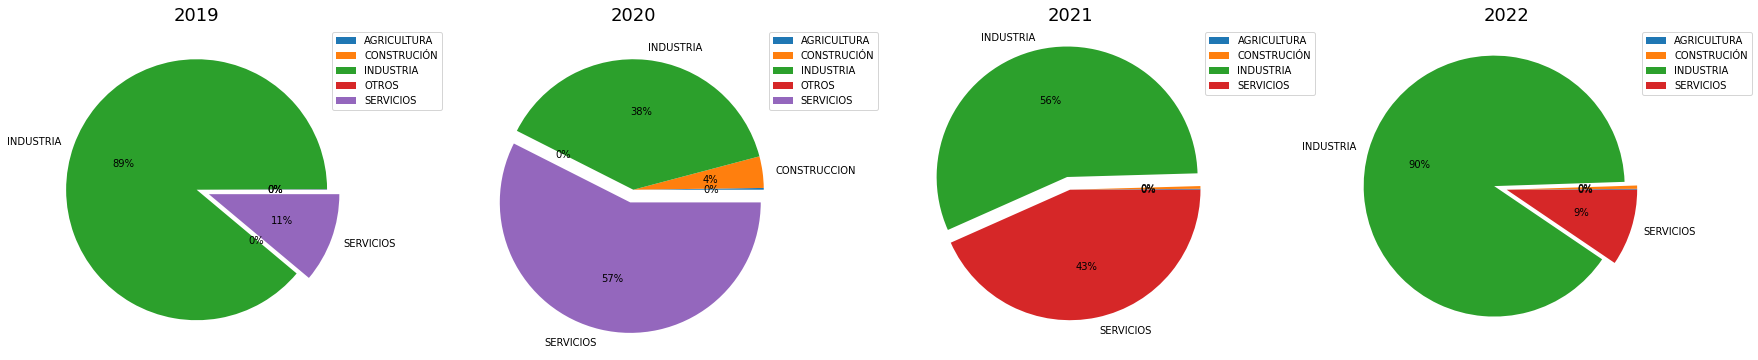

In [ ]:
# Aqui generamos 4 mini Dataframe, segmentados por años, para plotear en subplots y poder comparar año a año.

Sector_2019 = df_final.filter(['AÑO','SECTOR','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','SECTOR']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2019").reset_index()
Sector_2020 = df_final.filter(['AÑO','SECTOR','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','SECTOR']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2020").reset_index()
Sector_2021 = df_final.filter(['AÑO','SECTOR','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','SECTOR']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2021").reset_index()
Sector_2022 = df_final.filter(['AÑO','SECTOR','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','SECTOR']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2022").reset_index()

# Creamos la figura y las 4 subfiguras, indicando el tamaño.
fig, axs = plt.subplots(1,4,figsize=[30,6])

# Pasamos los datos a cada subplot, añadiendo etiquetas, leyendas y titulos para su correcta visualizacion.

axs[0].pie(Sector_2019['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',explode=[0,0,0,0,0.1],labels= ['','','INDUSTRIA','','SERVICIOS'])
axs[0].legend(Sector_2019['SECTOR'],bbox_to_anchor=(0.9, 1), loc=2)
axs[0].set_title('2019',fontsize=18)

axs[1].pie(Sector_2020['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',explode=[0,0,0,0,0.1],labels= ['','CONSTRUCCION','INDUSTRIA','','SERVICIOS'])
axs[1].legend(Sector_2020['SECTOR'],bbox_to_anchor=(0.9, 1), loc=2)
axs[1].set_title('2020',fontsize=18)

axs[2].pie(Sector_2021['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',explode=[0,0,0.1,0],labels= ['','','INDUSTRIA','SERVICIOS'])
axs[2].legend(Sector_2021['SECTOR'],bbox_to_anchor=(0.9, 1), loc=2)
axs[2].set_title('2021',fontsize=18)

axs[3].pie(Sector_2022['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',explode=[0,0,0.1,0],labels= ['','','INDUSTRIA','SERVICIOS'])
axs[3].legend(Sector_2022['SECTOR'],bbox_to_anchor=(0.9, 1), loc=2)
axs[3].set_title('2022',fontsize=18);

________________________________________________________________________________

Aqui podemos ver el cambio en porcentajes, del impacto sobre cada sector durante los años.

Recordamos que en tenemos:

- 2019 --> 35626 trabajores suspendidos.
- 2020 --> 245008 trabajores suspendidos.
- 2021 --> 65416 trabajores suspendidos.
- 2022 --> 23184 trabajores suspendidos. (datos hasta agosto 2022)

Durante estos años la industria ha recibido mayor impacto, salvo en plena pandemia, que el sector servicios se llevo la mayor parte. 
El descenso en el sector servicios ha ido descendiendo gradualmente,
segun ha ido disminuyendo los casos de covid, pero la industria ha quedado muy 
afectada manteniendo un 90% respecto a los otros sectores en 2022.

(observaremos mes a mes mas adelante para comprobar los meses clave)


________________________________________________________________________________


In [ ]:
 Solicitudes_Sector_Suma = (
                            df_final.filter(['AÑO','SECTOR','TOTAL_TRAB_SUSPENDIDOS','TRAB_HOMBRES_SUSPENDIDOS','TRAB_MUJERES_SUSPENDIDAS','TRAB_GENERO_NO_DEFINIDO_SUSPENSION'])
                                    .groupby(['AÑO','SECTOR'])
                                    .sum(['TOTAL_TRAB_SUSPENDIDOS','TRAB_HOMBRES_SUS','TRAB_MUJERES_SUSPENDIDAS','TRAB_GENERO_NO_DEFINIDO_SUSPENSION'])
                                    .query("AÑO >= 2019")
                                    .rename(columns={'TRAB_HOMBRES_SUSPENDIDOS':'PORCENTAJE_HOMBRES','TRAB_MUJERES_SUSPENDIDAS':'PORCENTAJE_MUJERES',
                                                     'TRAB_GENERO_NO_DEFINIDO_SUSPENSION':'PORCENTAJE_SIN_DEFINIR'})
                                    .assign(PORCENTAJE_HOMBRES = lambda x: x.PORCENTAJE_HOMBRES/x.TOTAL_TRAB_SUSPENDIDOS*100,
                                            PORCENTAJE_MUJERES = lambda x: x.PORCENTAJE_MUJERES/x.TOTAL_TRAB_SUSPENDIDOS*100,
                                            PORCENTAJE_SIN_DEFINIR = lambda x: x.PORCENTAJE_SIN_DEFINIR/x.TOTAL_TRAB_SUSPENDIDOS*100)
                                    .replace(np.nan,0)
                                    .round(2)
                                    
                                    .query("AÑO >= 2019")
                          )

# Pasamos un mapa de calor a nuestro DataFrame coloreando los valores mas altos de cada columna para identificarlos mas facilmente.
cm = sns.diverging_palette(250,100, as_cmap=True)
Solicitudes_Sector_Suma.style.background_gradient(cmap=cm).format(precision= 2)

________________________________________________________________________________

En esta tabla añadimos los valores absolutos por sector, y segmentamos por genero.

A destacar que los porcentajes entre hombres y mujeres, varian dependiendo del sector. 

- El porcentaje de mujeres afectadas fue mayor que el de los hombres en los años 2020 y 2021 (covid), en el sector servicios. Ademas cabe destacar la cantidad por lo elevado que fue el numero de suspensiones en 2020. Fueron 70.000 mujeres suspendidas de empleo ese año en la GVA.

- La agricultura se ha mantenido entre un 15% y 20% de suspension de mujeres, mientras que en 2022 ha caido a 0%.

- El 51.1% de suspensiones de personas del año 2021, sin genero definido, pertenecen a la industria.


________________________________________________________________________________


In [ ]:
# Filtramos los datos desde 2019 en un copia del df original para plotear en el mapa.

df_Mapa_Sector = df_final.query("AÑO >= 2019")

# Creamos nuestro mapa con las coordenadas y segmentamos por sector. 
# Indicamos tamaño del mapa, zoom, estilo e incluimos una barra de año para filtrar año a año.

fig = px.scatter_mapbox(df_Mapa_Sector, 
                        lat="LATITUD", 
                        lon="LONGITUD",     
                        color="SECTOR", 
                        color_continuous_scale='viridis',
                        zoom= 4.7,
                        mapbox_style = 'carto-positron',
                        animation_frame="AÑO",
                        width = 1000,
                        height = 800,
                        category_orders={'AÑO':[2019,2020,2021,2022]})
fig.show()

________________________________________________________________________________

ESTE MAPA ES INTERACTIVO.

Podemo filtrar por año y sector, pudiendo asi observar las localizaciones de las empresas afectadas en el mapa.

*** Cuidado pues hay localizaciones que solapan a otras, asi que aconsejo filtrar los sectores para visualizar mejor los sectores.


Como primeras conclusiones, vemos que el año 2020 afecto de manera generalizada, siempre teniendo en cuenta que los datos provienen de la GVA.

Se puede observar que el año 2021 tambien castigó mucho al sector servicios pero de manera mas centralizada en la propia CC.AA 
En  2022 empieza ya hay una recuperacion aunque sigue habiendo solicitudes en varias partes de la comunidad.

________________________________________________________________________________

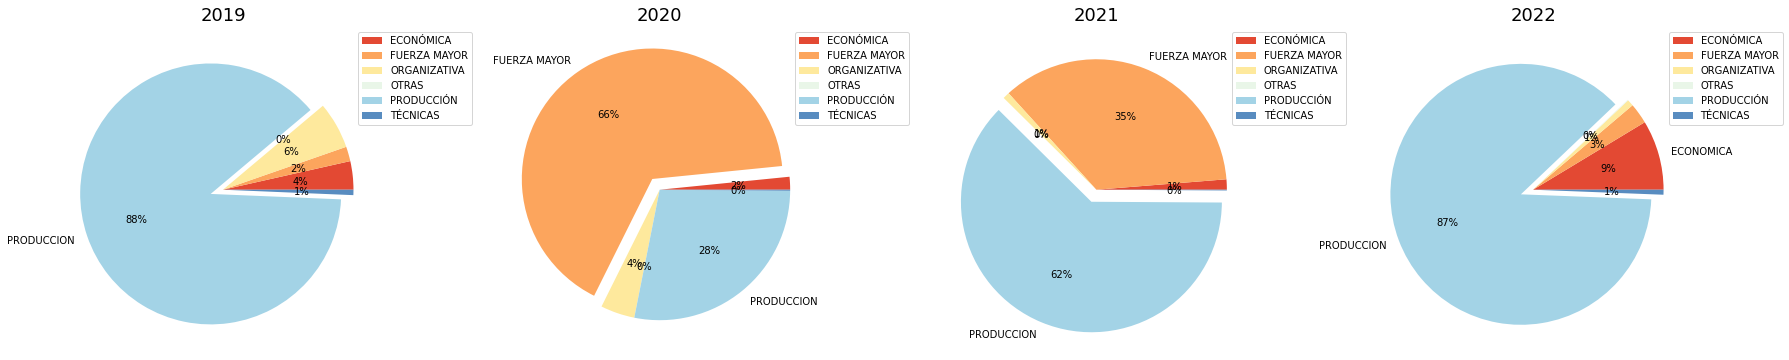

In [ ]:
# Aqui generamos 4 mini Dataframe, segmentados por años, para plotear en subplots y poder comparar año a año.

Causa_2019 = df_final.filter(['AÑO','CAUSA_SUSPENSION','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','CAUSA_SUSPENSION']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2019").reset_index()
Causa_2020 = df_final.filter(['AÑO','CAUSA_SUSPENSION','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','CAUSA_SUSPENSION']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2020").reset_index()
Causa_2021 = df_final.filter(['AÑO','CAUSA_SUSPENSION','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','CAUSA_SUSPENSION']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2021").reset_index()
Causa_2022 = df_final.filter(['AÑO','CAUSA_SUSPENSION','TOTAL_TRAB_SUSPENDIDOS']).groupby(['AÑO','CAUSA_SUSPENSION']).sum('TOTAL_TRAB_SUSPENDIDOS').query("AÑO == 2022").reset_index()

# Creamos la figura y las 4 subfiguras, indicando el tamaño y el color.
fig, axs = plt.subplots(1,4,figsize=[30,6])
colores = sns.color_palette('RdYlBu')

# Pasamos los datos a cada subplot, añadiendo etiquetas, leyendas y titulos para su correcta visualizacion.

axs[0].pie(Causa_2019['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',colors = colores, explode=[0,0,0,0,0.1,0],labels= ['','','','','PRODUCCION',''])
axs[0].legend(Causa_2019['CAUSA_SUSPENSION'],bbox_to_anchor=(0.9, 1), loc=2)
axs[0].set_title('2019',fontsize=18)

axs[1].pie(Causa_2020['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',colors = colores, explode=[0,0.1,0,0,0,0],labels= ['','FUERZA MAYOR','','','PRODUCCION',''])
axs[1].legend(Causa_2020['CAUSA_SUSPENSION'],bbox_to_anchor=(0.9, 1), loc=2)
axs[1].set_title('2020',fontsize=18)

axs[2].pie(Causa_2021['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',colors = colores, explode=[0,0,0,0,0.1,0],labels= ['','FUERZA MAYOR','','','PRODUCCION',''])
axs[2].legend(Causa_2021['CAUSA_SUSPENSION'],bbox_to_anchor=(0.9, 1), loc=2)
axs[2].set_title('2021',fontsize=18)

axs[3].pie(Causa_2022['TOTAL_TRAB_SUSPENDIDOS'],autopct = '%0.0f%%',colors = colores, explode=[0,0,0,0,0.1,0],labels= ['ECONOMICA','','','','PRODUCCION',''])
axs[3].legend(Causa_2022['CAUSA_SUSPENSION'],bbox_to_anchor=(0.9, 1), loc=2)
axs[3].set_title('2022',fontsize=18);

________________________________________________________________________________


En 2020 y 2021 se observan el impacto de las presentaciones por fuerza mayor (pandemia).

En 2019 y en 2022 podemos deducir que las suspensiones presentadas por baja producción fueron muy superiores al resto.

________________________________________________________________________________

In [ ]:
# Filtramos los datos desde 2019 en un copia del df original para plotear en el mapa.

df_Mapa_Causa = df_final.query("AÑO >= 2019")

# Creamos nuestro mapa con las coordenadas y segmentamos por causa. 
# Indicamos tamaño del mapa, zoom, estilo e incluimos una barra de año para filtrar año a año.

fig = px.scatter_mapbox(df_Mapa_Causa, 
                        lat="LATITUD", 
                        lon="LONGITUD",     
                        color="CAUSA_SUSPENSION", 
                        color_continuous_scale='viridis',
                        zoom= 4.7,
                        mapbox_style = 'carto-positron',
                        animation_frame="AÑO",
                        width = 1000,
                        height = 800,
                        category_orders={'AÑO':[2019,2020,2021,2022]})
fig.show()

________________________________________________________________________________

ESTE MAPA ES INTERACTIVO.

Podemo filtrar por año y causa de suspension, pudiendo asi observar las localizaciones de las empresas afectadas en el mapa.

*** Cuidado pues hay localizaciones que solapan a otras, asi que aconsejo filtrar los motivos para visualizar mejor las emplazamientos.

En este mapa vemos tambien el impacto de la pandemia en 2020, teniendo muy dispersas las solicitudes por fuerza mayor y una gran concentracion del resto de causas en la propia comunidad.

En 2021 hay un pequeño descenso en comparacion con 2020, pero no es hasta 2021 cuando empieza una recuperación mas notable.



________________________________________________________________________________


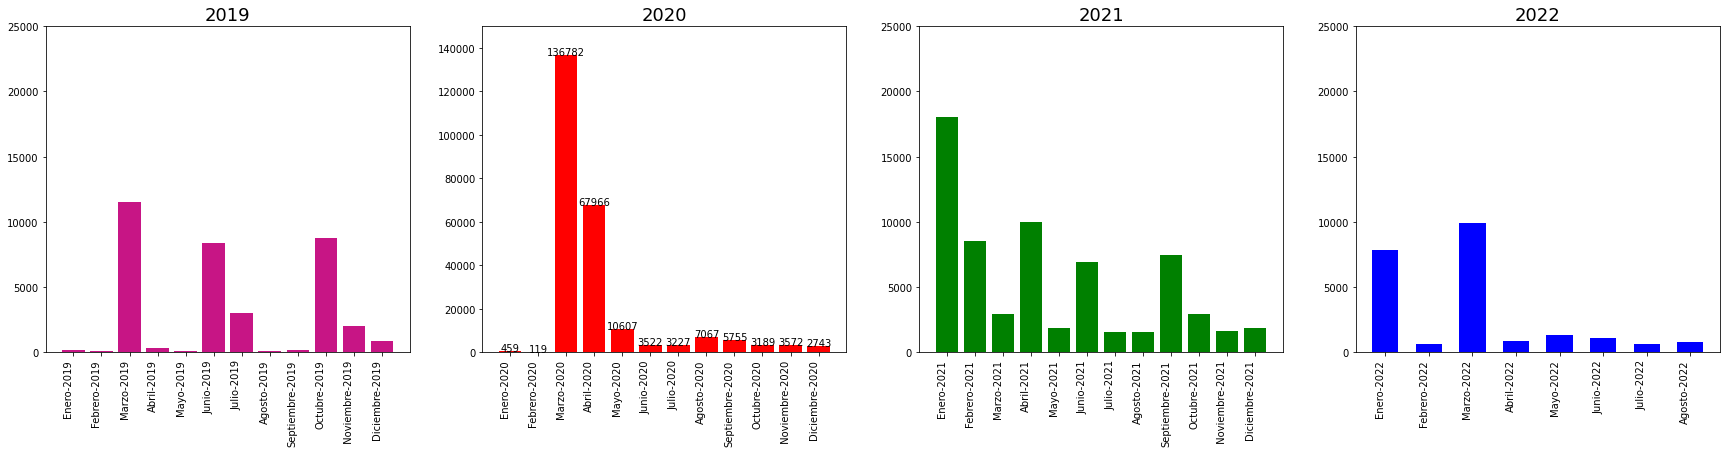

In [ ]:
# Aqui generamos 4 mini Dataframe, segmentados por años, para plotear en subplots y poder comparar año a año.

df_2019 = df_final.query("AÑO == 2019").groupby('MES_AÑO').sum('TOTAL_TRAB_SUSPENDIDOS').filter(['MES_AÑO','TOTAL_TRAB_SUSPENDIDOS']).reset_index().assign(orden_meses = [11,4,8,12,1,2,7,6,3,5,10,9]).sort_values('orden_meses')
df_2020 = df_final.query("AÑO == 2020").groupby('MES_AÑO').sum('TOTAL_TRAB_SUSPENDIDOS').filter(['MES_AÑO','TOTAL_TRAB_SUSPENDIDOS']).reset_index().assign(orden_meses = [11,4,8,12,1,2,7,6,3,5,10,9]).sort_values('orden_meses')
df_2021 = df_final.query("AÑO == 2021").groupby('MES_AÑO').sum('TOTAL_TRAB_SUSPENDIDOS').filter(['MES_AÑO','TOTAL_TRAB_SUSPENDIDOS']).reset_index().assign(orden_meses = [11,4,8,12,1,2,7,6,3,5,10,9]).sort_values('orden_meses')
df_2022 = df_final.query("AÑO == 2022").groupby('MES_AÑO').sum('TOTAL_TRAB_SUSPENDIDOS').filter(['MES_AÑO','TOTAL_TRAB_SUSPENDIDOS']).reset_index().assign(orden_meses = [4,8,1,2,7,6,3,5]).sort_values('orden_meses')

# Creamos la figura y las 4 subfiguras, indicando el tamaño.
fig, axs = plt.subplots(1,4,figsize=[30,6])

# Pasamos los datos a cada subplot, añadiendo etiquetas, leyendas y titulos para su correcta visualizacion.
# Tambien definimos las escalas de cada subplot.

axs[0].bar(df_2019['MES_AÑO'],df_2019['TOTAL_TRAB_SUSPENDIDOS'],width=0.8 ,color='mediumvioletred')
axs[0].set_xticklabels(df_2019['MES_AÑO'], rotation=90, ha='right')
axs[0].set_title('2019',fontsize=18)
axs[0].set_ylim(0, 25000)

axs[1].bar(df_2020['MES_AÑO'],df_2020['TOTAL_TRAB_SUSPENDIDOS'],width=0.8 ,color='red')
axs[1].set_xticklabels(df_2020['MES_AÑO'], rotation=90, ha='right')
axs[1].set_title('2020',fontsize=18)
axs[1].set_ylim(0, 150000)

axs[2].bar(df_2021['MES_AÑO'],df_2021['TOTAL_TRAB_SUSPENDIDOS'],width=0.8 ,color='green')
axs[2].set_xticklabels(df_2021['MES_AÑO'], rotation=90, ha='right')
axs[2].set_title('2021',fontsize=18)
axs[2].set_ylim(0, 25000)

axs[3].bar(df_2022['MES_AÑO'],df_2022['TOTAL_TRAB_SUSPENDIDOS'],width=0.6 ,color='blue')
axs[3].set_xticklabels(df_2022['MES_AÑO'], rotation=90, ha='right')
axs[3].set_title('2022',fontsize=18)
axs[3].set_ylim(0, 25000)


# Usamos un bucle for para etiquetar los valores absolutos, mejorando la visualizacion. 
# Como la escala del grafico de 2020 es diferente, al etiquetarlo evitamos errores de percepcion.

for i, v in enumerate(df_2020['TOTAL_TRAB_SUSPENDIDOS']):
    axs[1].text(i, v+25, "%d" %v, ha="center");

________________________________________________________________________________


** MUY IMPORTANTE LA ESCALA DEL EJE Y DEL GRAFICO DE 2020.

Con este gráfico he intentado detectar las olas de la pandemia, las restricciones y los inicios de vacaciones, navidades y temporada alta.

No hay duda que el inicio de la pandemia no tiene precedentes, Marzo y Abril de 2020 son los picos históricos de personas suspendidas de empleo.

No nos dejemos engañar por la escala, para ello hemos añadido unas etiquetas.

En Agosto y Septiembre de 2020 tambien se mandaron un gran número de personas al ERTE. Ademas existe un patrón al finalizar navidad (Enero), Semana Santa y antes y despues de verano durante todo el 2021.

No es hasta pasada la Semana santa de 2022 que se puede ver una verdadera recuperacion.



________________________________________________________________________________

